# Predcition of Hospital Admission Related to Sinusitis

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sinusitis. We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [63]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [64]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [65]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [66]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'sinusitis_date_'+str(i), 'sinusitis_ab_date_'+str(i), 'sinusitis_ab_type_'+str(i),
                   'incdt_sinusitis_date_'+str(i), 'admitted_sinusitis_date_'+str(i), 'sgss_gp_cov_sinusitis_date_'+str(i)]]
    
    #drop rows with no sinusitis reord
    datum = datum[datum['sinusitis_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with sinusitis_i
    datum = datum[datum['sgss_gp_cov_sinusitis_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'sinusitis_date_'+str(i): 'sinusitis_date', 'sinusitis_ab_date_'+str(i): 'sinusitis_ab_date', 
                           'sinusitis_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_sinusitis_date_'+str(i): 'incdt_sinusitis_date', 'incdt_sinusitis_type_'+str(i): 'incdt_sinusitis_type',
                           'admitted_sinusitis_date_'+str(i): 'admitted_sinusitis_date',
                           'sgss_gp_cov_sinusitis_date_'+str(i): 'sgss_gp_cov_sinusitis_date'},
                inplace=True)
    
    return datum

In [ ]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [104]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [69]:
def cox_build(infection, infection_type, data, data_no_abs): #data_sinusitis_incdt, data_sinusitis_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_sinusitis_admitted',
            event_col='event_sinusitis_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_sinusitis_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_sinusitis_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [70]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [71]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [72]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [73]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_sinusitis.csv.gz')

In [74]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [75]:
#process 20 sinusitiss and concatenate them 
data_sinusitis_1 = proc_infec_data(data,1)
data_sinusitis_2 = proc_infec_data(data,2)
data_sinusitis_3 = proc_infec_data(data,3)
data_sinusitis_4 = proc_infec_data(data,4)
data_sinusitis_5 = proc_infec_data(data,5)
data_sinusitis_6 = proc_infec_data(data,6)
data_sinusitis_7 = proc_infec_data(data,7)
data_sinusitis_8 = proc_infec_data(data,8)
data_sinusitis_9 = proc_infec_data(data,9)
data_sinusitis_10 = proc_infec_data(data,10)
data_sinusitis_11 = proc_infec_data(data,11)
data_sinusitis_12 = proc_infec_data(data,12)
data_sinusitis_13 = proc_infec_data(data,13)
data_sinusitis_14 = proc_infec_data(data,14)
data_sinusitis_15 = proc_infec_data(data,15)
data_sinusitis_16 = proc_infec_data(data,16)
data_sinusitis_17 = proc_infec_data(data,17)
data_sinusitis_18 = proc_infec_data(data,18)
data_sinusitis_19 = proc_infec_data(data,19)
data_sinusitis_20 = proc_infec_data(data,20)

data_sinusitis = pd.concat([data_sinusitis_1, data_sinusitis_2, data_sinusitis_3, data_sinusitis_4, data_sinusitis_5, data_sinusitis_6, data_sinusitis_7, data_sinusitis_8, data_sinusitis_9, data_sinusitis_10, data_sinusitis_11, data_sinusitis_12, data_sinusitis_13, data_sinusitis_14, data_sinusitis_15, data_sinusitis_16, data_sinusitis_17, data_sinusitis_18, data_sinusitis_19, data_sinusitis_20])
data_sinusitis.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [76]:
##add variable season
#convert data types
data_sinusitis['sinusitis_date'] = data_sinusitis['sinusitis_date'].astype('datetime64[ns]')
data_sinusitis['admitted_sinusitis_date'] = data_sinusitis['admitted_sinusitis_date'].astype('datetime64[ns]')
data_sinusitis.died_date = data_sinusitis.died_date.astype('datetime64[ns]')
data_sinusitis.deregistered_date = data_sinusitis.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_sinusitis['date'] = data_sinusitis['sinusitis_date'] 
data_sinusitis['date'] = data_sinusitis['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_sinusitis with today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_1_month_date_y_m]
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of sinusitis records
data_sinusitis['season'] = np.nan
data_sinusitis['date_month'] = pd.DatetimeIndex(data_sinusitis['date']).month

conditions = [
    (data_sinusitis['date_month'] >= 3) & (data_sinusitis['date_month'] <= 5),
    (data_sinusitis['date_month'] >= 6) & (data_sinusitis['date_month'] <= 8),
    (data_sinusitis['date_month'] >= 9) & (data_sinusitis['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_sinusitis['season'] = np.select(conditions, choices, default='winter')

In [77]:
#add variable time period
data_sinusitis.loc[(data_sinusitis['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_sinusitis.loc[((data_sinusitis['date'] >= '2020-01') & (data_sinusitis['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_sinusitis.loc[(data_sinusitis['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [78]:
data_sinusitis['date'].max()

'2023-02'

#### event and duration

In [79]:
#scenario 1
#not hosped (nothing happened)
data_sinusitis.loc[data_sinusitis['admitted_sinusitis_date'].isnull(), 'event_sinusitis_admitted'] = 0

In [80]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] >= 0) & (data_sinusitis['delta_sinusitis_admitted'] <= 30)), 'event_sinusitis_admitted'] = 1

#scenario 2
#drop whoever was admitted before sinusitis consultation, i.e. negative value for delta_sinusitis_admitted
data_sinusitis = data_sinusitis[~(data_sinusitis['delta_sinusitis_admitted'] < 0)]

In [81]:
#scenario 3
#censor died patients
data_sinusitis['delta_admitted_died'] = (data_sinusitis['died_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_died'] >= 0) & (data_sinusitis['delta_admitted_died'] <= 30)), 'event_sinusitis_admitted'] = 0

#scenario 3
#censor deregistered patients
data_sinusitis['delta_admitted_deregistered'] = (data_sinusitis['deregistered_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_deregistered'] > 0) & (data_sinusitis['delta_admitted_deregistered'] <= 30)), 'event_sinusitis_admitted'] = 0

#agg scenario 3s
data_sinusitis['delta_admitted_died_deregistered'] = data_sinusitis['delta_admitted_deregistered'].combine_first(data_sinusitis['delta_admitted_died'])
data_sinusitis.loc[data_sinusitis['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [82]:
#scenario 1
#any other patients (nothing happened)
data_sinusitis['event_sinusitis_admitted'] = data_sinusitis['event_sinusitis_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['delta_sinusitis_admitted'].combine_first(data_sinusitis['delta_admitted_died_deregistered'])
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['duration_sinusitis_admitted'].replace(np.NaN, 30)
data_sinusitis.loc[(data_sinusitis['duration_sinusitis_admitted'] > 30), 'duration_sinusitis_admitted'] = 30

#give value 1 to event_sinusitis_admitted if duration_sinusitis_admitted is greater or equal to 0 and less than 30
data_sinusitis.loc[((data_sinusitis['duration_sinusitis_admitted'] >= 0) & (data_sinusitis['duration_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

#drop any rows with value 0 in duration column
data_sinusitis = data_sinusitis[~(data_sinusitis['duration_sinusitis_admitted'] == 0)]

In [83]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] > 0) & (data_sinusitis['delta_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [84]:
#drop anybody with age less than 18 or 0!
data_sinusitis = data_sinusitis[~(data_sinusitis['age'] < 18)] 
data_sinusitis['age'][data_sinusitis['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '0-4']
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_sinusitis['bmi'][data_sinusitis['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_sinusitis['bmi'] = data_sinusitis['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_sinusitis['antibacterial_brit'][data_sinusitis['antibacterial_brit'] < 0] = np.nan

In [85]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"smoking": dict_smoking})

In [86]:
#drop rows with missing region
if ('region' in data_sinusitis.columns) and (data_sinusitis['region'].isnull().sum() > 0):
   data_sinusitis = data_sinusitis[data_sinusitis['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_sinusitis.columns) and (data_sinusitis['antibacterial_brit'].isnull().sum() > 0):
    data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_sinusitis.columns) and (data_sinusitis['ethnicity'].isnull().sum() > 0):
    data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_sinusitis.columns) and (data_sinusitis['smoking'].isnull().sum() > 0):
    data_sinusitis['smoking'] = data_sinusitis['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_sinusitis.columns) and (data_sinusitis['imd'].isnull().sum() > 0):
    data_sinusitis['imd'] = data_sinusitis['imd'].fillna(0)

In [87]:
#missing values of bmi assign 5 and 0; categorise bmi
data_sinusitis['bmi_cat'] = 5

for idx, x in enumerate(data_sinusitis['bmi_cat']):
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 30:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 25) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 30):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 18.5) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 25):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 18.5:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_sinusitis.columns) and (data_sinusitis['bmi_cat'].isnull().sum() > 0):
    data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].fillna(0)

In [88]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_sinusitis.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_sinusitis['ab_type_cat'] = np.where(data_sinusitis['ab_type'].isin(ab_series[mask].index),'other',data_sinusitis['ab_type'])
#assign no to non ab users
data_sinusitis.loc[data_sinusitis['sinusitis_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_sinusitis['ab_type_cat'] = data_sinusitis['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [89]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"ethnicity": dict_ethnicity})
data_sinusitis = data_sinusitis.replace({"smoking": dict_smoking})
data_sinusitis = data_sinusitis.replace({"imd": dict_imd})
data_sinusitis = data_sinusitis.replace({"bmi_cat": dict_bmi})
data_sinusitis = data_sinusitis.replace({"flu_vaccine": dict_flu})
data_sinusitis = data_sinusitis.replace({"region": dict_region})
data_sinusitis = data_sinusitis.replace({"age_cat": dict_age})
data_sinusitis = data_sinusitis.replace({"ab_type_cat": dict_ab_type})

In [90]:
data_sinusitis.ethnicity.value_counts('NA')

white      0.601210
unknown    0.248238
asian      0.075755
other      0.074798
Name: ethnicity, dtype: float64

In [91]:
data_sinusitis.smoking.value_counts('NA')

unknown         0.413721
smoker          0.388510
never_smoked    0.132783
ex_smoker       0.064986
Name: smoking_status, dtype: float64

In [92]:
data_sinusitis.bmi_cat.value_counts('NA')

obese             0.517428
unknown           0.255077
overweight        0.112928
healthy_weight    0.082524
underweight       0.032044
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [93]:
#categorise CCI
data_sinusitis['CCI_cat'] = pd.cut(data_sinusitis['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_sinusitis['antibacterial_brit'].clip(0, data_sinusitis['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

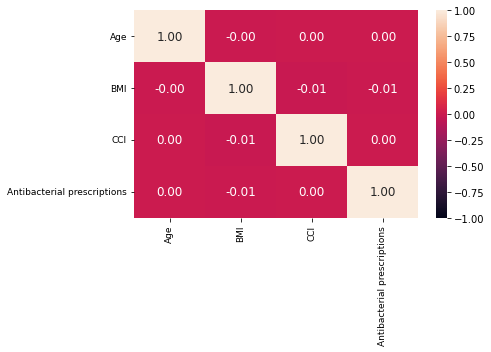

In [94]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_sinusitis[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/corr_sinusitis.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [95]:
data_sinusitis = data_sinusitis[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'sinusitis_ab_date', 'ab_type_cat', 'incdt_sinusitis_date', 'date', 'period',
                                   'event_sinusitis_admitted', 'duration_sinusitis_admitted'
                                    ]]

In [96]:
#switch variable sinusitis_ab_date into a binary variable
data_sinusitis[['ab_binary']] = data_sinusitis[['sinusitis_ab_date']].where(data_sinusitis[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_sinusitis_incdt = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 0]
data_sinusitis_prevl = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 1]

#no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt = data_sinusitis_incdt[data_sinusitis_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_sinusitis_abs_incdt = data_sinusitis_incdt[data_sinusitis_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_sinusitis_no_abs_prevl = data_sinusitis_prevl[data_sinusitis_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_sinusitis_abs_prevl = data_sinusitis_prevl[data_sinusitis_prevl['ab_binary'] == 1]

In [97]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_sinusitis_incdt_prepandemic = data_sinusitis_incdt[data_sinusitis_incdt['period'] == 'prepandemic']
data_sinusitis_incdt_during_pandemic = data_sinusitis_incdt[(data_sinusitis_incdt['period'] == 'during_pandemic')]
data_sinusitis_incdt_post_2nd_lockdown = data_sinusitis_incdt[data_sinusitis_incdt['period'] == 'post_2nd_lockdown']
data_sinusitis_prevl_prepandemic = data_sinusitis_prevl[data_sinusitis_prevl['period'] == 'prepandemic']
data_sinusitis_prevl_during_pandemic = data_sinusitis_prevl[(data_sinusitis_prevl['period'] == 'during_pandemic')]
data_sinusitis_prevl_post_2nd_lockdown = data_sinusitis_prevl[data_sinusitis_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt_prepandemic = data_sinusitis_incdt_prepandemic[data_sinusitis_incdt_prepandemic['ab_binary'] == 0]
data_sinusitis_no_abs_incdt_during_pandemic = data_sinusitis_incdt_during_pandemic[data_sinusitis_incdt_during_pandemic['ab_binary'] == 0]
data_sinusitis_no_abs_incdt_post_2nd_lockdown = data_sinusitis_incdt_post_2nd_lockdown[data_sinusitis_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_prepandemic = data_sinusitis_prevl_prepandemic[data_sinusitis_prevl_prepandemic['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_during_pandemic = data_sinusitis_prevl_during_pandemic[data_sinusitis_prevl_during_pandemic['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_post_2nd_lockdown = data_sinusitis_prevl_post_2nd_lockdown[data_sinusitis_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [98]:
#store data for plotting hosp admission counts and percentages
%store data_sinusitis
# save data
data_sinusitis.to_csv('../output/hospitalisation_prediction_sinusitis/data_sinusitis.csv')

Stored 'data_sinusitis' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [100]:
#make summary tables
make_summary_table('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)
make_summary_table('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)
make_summary_table('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)
make_summary_table('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 113036 total observations, 112235 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 113036
number of events observed = 801
   partial log-likelihood = -9302.38
         time fit was run = 2023-06-29 00:17:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.07       0.94       0.10            -0.27             0.14                 0.76                 1.15
CCI_cat[T.medium]               -0.06       0.94       0.12            -0.29             0.16                 0.75                 1.18
CCI_cat[T.high]                 -0.06       0.94       0.14            -0.33             0.21                 0.72                 1.24
CCI_cat[T.very_high]            -0.04       0.96       0.12            -0.28             0.20                 0.76                 1.22
age_cat[T.25_34]                 0.06       1.07       0.13            -0.19             0.32                 0.83                 1.38
age_cat[T.35_44]                 0.10       1.11       0.13            -0.15             0.36                 0.86                 1.43
age_cat[T.45_54]                -0.14       0.87       0.14            -0.41             0.13                 0.67                 1.14
age_cat[T.55_64]                -0.01       0.99       0.13            -0.27             0.25                 0.77                 1.29
age_cat[T.65_74]                -0.11       0.90       0.14            -0.38             0.16                 0.69                 1.17
age_cat[T.75_more]               0.05       1.05       0.13            -0.20             0.31                 0.82                 1.36
antibacterial_brit              -0.02       0.98       0.02            -0.07             0.03                 0.94                 1.03
bmi_cat[T.obese]                -0.14       0.87       0.12            -0.38             0.10                 0.68                 1.11
bmi_cat[T.overweight]           -0.25       0.78       0.16            -0.56             0.06                 0.57                 1.07
bmi_cat[T.underweight]          -0.03       0.97       0.22            -0.46             0.40                 0.63                 1.50
bmi_cat[T.unknown]              -0.17       0.84       0.13            -0.43             0.09                 0.65                 1.10
ethnicity[T.other]              -0.18       0.84       0.18            -0.53             0.18                 0.59                 1.19
ethnicity[T.unknown]            -0.12       0.89       0.14            -0.39             0.16                 0.67                 1.18
ethnicity[T.white]              -0.09       0.91       0.13            -0.35             0.16                 0.70                 1.17
flu_vaccine[T.yes]               0.19       1.21       0.11            -0.02             0.40                 0.98                 1.50
imd[T.medium]                    0.11       1.11       0.11            -0.11             0.33                 0.89                 1.39
imd[T.unaffluent]               -0.10       0.91       0.12            -0.33             0.14                 0.72                 1.14
imd[T.unknown]                   0.01       1.01       0.18            -0.34             0.36                 0.71                 1.43
imd[T.very_affluent]             0.05       1.05       0.11            -0.17             0.28                 0.84                 1.32
imd[T.very_unaffluent]           0.09       1.09       0.11            -0.14             0.31                 0.87                 1.37
region[T.east_midlands]         -0.15       0.86       

12247


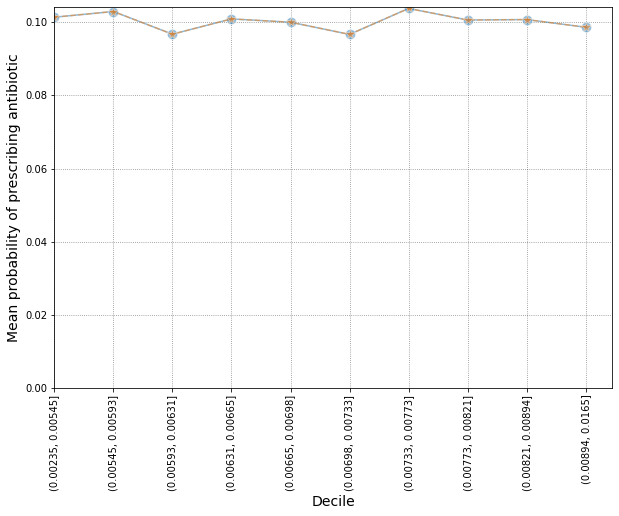


AUROC of LR for deciles with development and validation data: 0.50857 and 0.49886
AUROC of RF for deciles with development and validation data: 0.51690 and 0.49687
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00235, 0.00545]  0.110168  0.103554  0.117206
bins_(0.00545, 0.00593]  0.113759  0.107093  0.120839
bins_(0.00593, 0.00631]  0.108738  0.102279  0.115606
bins_(0.00631, 0.00665]  0.113699  0.107040  0.120773
bins_(0.00665, 0.00698]  0.110870  0.104340  0.117809
bins_(0.00698, 0.00733]  0.106244  0.099912  0.112976
bins_(0.00733, 0.00773]  0.119480  0.112673  0.126697
bins_(0.00773, 0.00821]  0.110557  0.104097  0.117417
bins_(0.00821, 0.00894]  0.109573  0.103194  0.116346
bins_(0.00894, 0.0165]   0.107962  0.101635  0.114683
antibacterial_brit       1.000741  0.987805  1.013846

RF feature importance:
                           rf_coef
antibacterial_brit       0.602032
bins_(0.00733, 0.00773]  0.103414
bins_(0.00698, 0.00733]  0.049507
bins_(0.

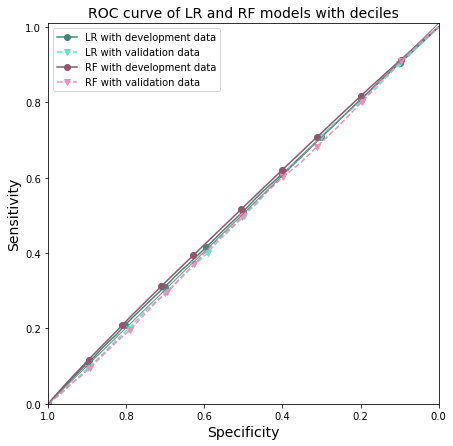

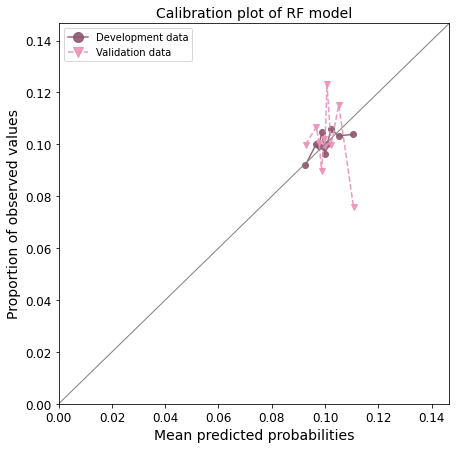

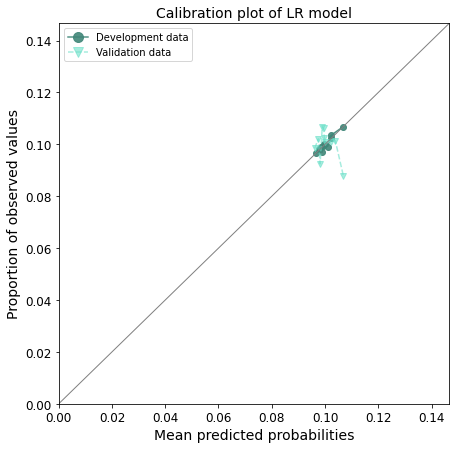


AUROC of LR for risk factors with development and validation data: 0.51538 and 0.50695
AUROC of RF for risk factors with development and validation data: 0.61349 and 0.50906
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.881668  0.000000       inf
age_cat_25_34                0.854079  0.000000       inf
age_cat_35_44                0.893284  0.000000       inf
age_cat_45_54                0.877687  0.000000       inf
age_cat_55_64                0.899308  0.000000       inf
age_cat_65_74                0.927209  0.000000       inf
age_cat_75_more              0.867840  0.000000       inf
sex_female                   0.645995  0.000000       inf
sex_male                     0.661346  0.000000       inf
CCI_cat_high                 0.864846       NaN       NaN
CCI_cat_low                  0.837410       NaN       NaN
CCI_cat_medium               0.830067       NaN       NaN
CCI_cat_very_high            0.833303       NaN      

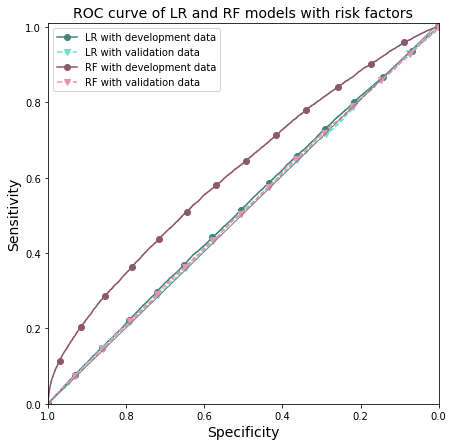

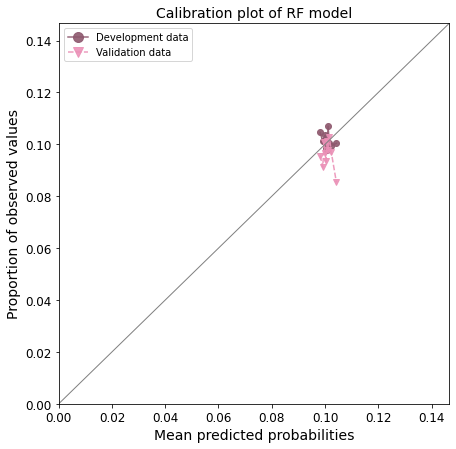

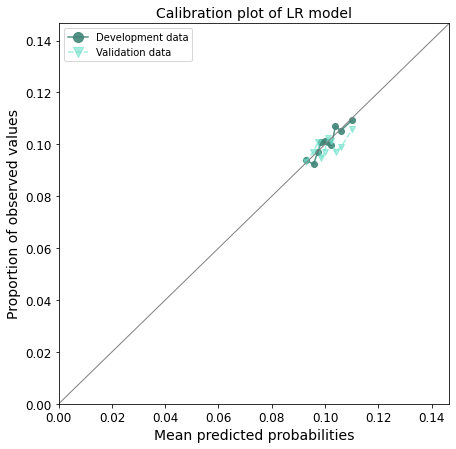

In [105]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt, prob_pred_sinusitis_no_abs_incdt_bin = cox_build('sinusitis', 'incdt', data_sinusitis_incdt, data_sinusitis_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models with deciles as predictors
    prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('sinusitis', 'incdt_deciles', prob_pred_sinusitis_no_abs_incdt)
    #make summary table of deciles
    make_summary_table_deciles('sinusitis', 'incdt', prob_pred_enc_lr_rf_incdt)
except:
    print("error_2: lr model did not converge or failed to finalise.")

try:
    #calibration plots of rf and lr with deciles
    calibration_rf_lr('sinusitis', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)
except:
    print("error_3: calibration of lr model did not converge or failed to finalise.")

try:
    #build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('sinusitis', 'incdt_riskfactors', prob_pred_sinusitis_no_abs_incdt)
except:
    print("error_4: lr model did not converge or failed to finalise.")

try:
    #calibration plots of rf and lr with risk factors
    calibration_rf_lr('sinusitis', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)
except:
    print("error_5: calibration of lr model did not converge or failed to finalise.")

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12470 total observations, 12393 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 12470
number of events observed = 77
   partial log-likelihood = -703.51
         time fit was run = 2023-06-28 23:02:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.34            -0.68             0.66                 0.51                 1.93
CCI_cat[T.medium]                0.13       1.14       0.36            -0.59             0.84                 0.56                 2.32
CCI_cat[T.high]                  0.10       1.10       0.43            -0.76             0.95                 0.47                 2.58
CCI_cat[T.very_high]            -0.21       0.81       0.41            -1.01             0.60                 0.36                 1.81
age_cat[T.25_34]                -0.52       0.59       0.42            -1.35             0.30                 0.26                 1.36
age_cat[T.35_44]                -0.11       0.89       0.38            -0.86             0.63                 0.42                 1.88
age_cat[T.45_54]                -0.32       0.73       0.40            -1.10             0.46                 0.33                 1.58
age_cat[T.55_64]                -0.25       0.78       0.39            -1.01             0.51                 0.36                 1.67
age_cat[T.65_74]                -0.15       0.86       0.38            -0.90             0.59                 0.41                 1.81
age_cat[T.75_more]              -1.32       0.27       0.56            -2.42            -0.21                 0.09                 0.81
antibacterial_brit               0.21       1.24       0.08             0.06             0.36                 1.07                 1.44
bmi_cat[T.obese]                -0.55       0.58       0.36            -1.26             0.16                 0.28                 1.17
bmi_cat[T.overweight]            0.12       1.12       0.41            -0.69             0.92                 0.50                 2.51
bmi_cat[T.underweight]          -0.60       0.55       0.78            -2.12             0.93                 0.12                 2.52
bmi_cat[T.unknown]              -0.58       0.56       0.40            -1.38             0.21                 0.25                 1.23
ethnicity[T.other]              -0.14       0.87       0.61            -1.33             1.05                 0.26                 2.86
ethnicity[T.unknown]             0.03       1.03       0.47            -0.89             0.95                 0.41                 2.58
ethnicity[T.white]               0.09       1.09       0.43            -0.76             0.94                 0.47                 2.57
flu_vaccine[T.yes]               0.07       1.07       0.37            -0.67             0.80                 0.51                 2.23
imd[T.medium]                   -0.37       0.69       0.39            -1.14             0.40                 0.32                 1.49
imd[T.unaffluent]               -0.17       0.85       0.37            -0.90             0.57                 0.41                 1.76
imd[T.unknown]                   0.64       1.90       0.43            -0.21             1.49                 0.81                 4.45
imd[T.very_affluent]            -0.19       0.82       0.37            -0.93             0.54                 0.40                 1.72
imd[T.very_unaffluent]           0.02       1.02       0.35            -0.68             0.71                 0.51                 2.04
region[T.east_midlands]          0.66       1.94       0.56 

12227


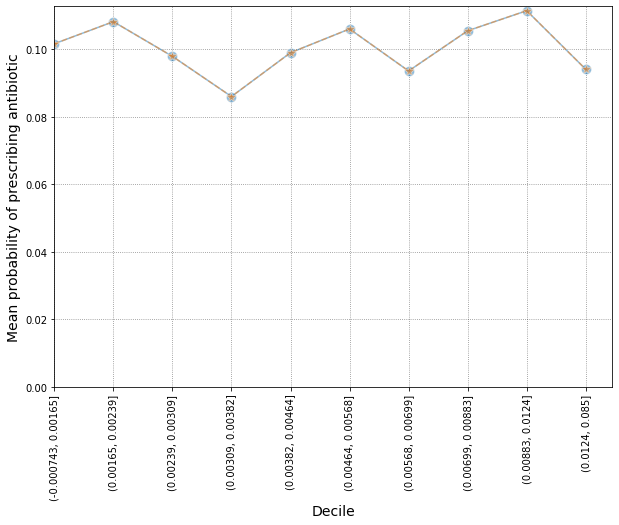


AUROC of LR for deciles with development and validation data: 0.52122 and 0.52433
AUROC of RF for deciles with development and validation data: 0.54586 and 0.52742
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000743, 0.00165]  0.110086  0.092323  0.131267
bins_(0.00165, 0.00239]    0.113495  0.095031  0.135548
bins_(0.00239, 0.00309]    0.110285  0.092335  0.131725
bins_(0.00309, 0.00382]    0.089487  0.073883  0.108387
bins_(0.00382, 0.00464]    0.111910  0.093408  0.134077
bins_(0.00464, 0.00568]    0.117195  0.097963  0.140203
bins_(0.00568, 0.00699]    0.103998  0.086068  0.125663
bins_(0.00699, 0.00883]    0.113034  0.093997  0.135926
bins_(0.00883, 0.0124]     0.115913  0.096045  0.139891
bins_(0.0124, 0.085]       0.094327  0.076230  0.116720
antibacterial_brit         1.016632  0.974744  1.060320

RF feature importance:
                             rf_coef
antibacterial_brit         0.591670
bins_(0.00309, 0.00382]    0.072144
bins_(0.0124

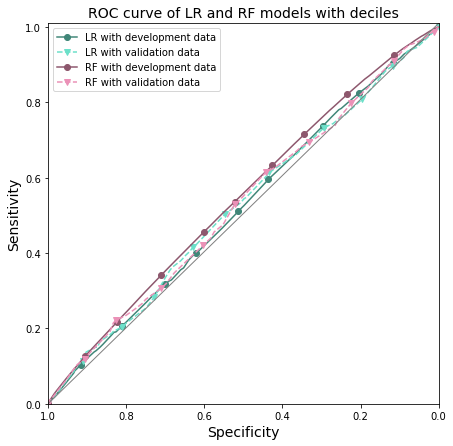

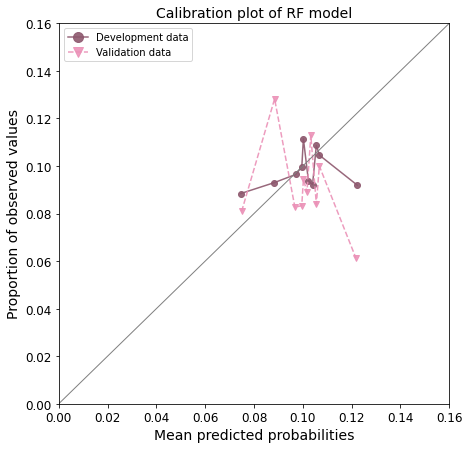

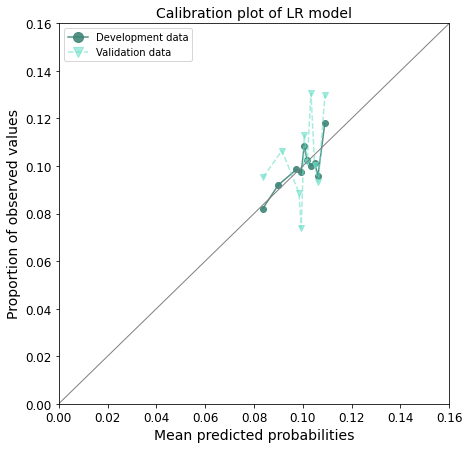


AUROC of LR for risk factors with development and validation data: 0.53579 and 0.51034
AUROC of RF for risk factors with development and validation data: 0.81442 and 0.49944
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.862479       NaN       NaN
age_cat_25_34                0.870132       NaN       NaN
age_cat_35_44                0.953915       NaN       NaN
age_cat_45_54                0.895245       NaN       NaN
age_cat_55_64                0.817461       NaN       NaN
age_cat_65_74                0.836601       NaN       NaN
age_cat_75_more              0.997286       NaN       NaN
sex_female                   0.671940  0.000000       inf
sex_male                     0.650519  0.000000       inf
CCI_cat_high                 0.851495  0.000000       inf
CCI_cat_low                  0.841141  0.000000       inf
CCI_cat_medium               0.865837  0.000000       inf
CCI_cat_very_high            0.791490  0.000000      

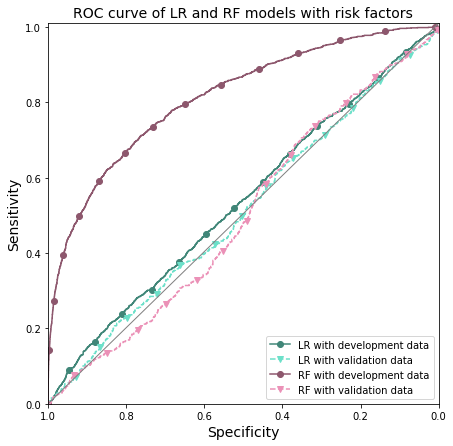

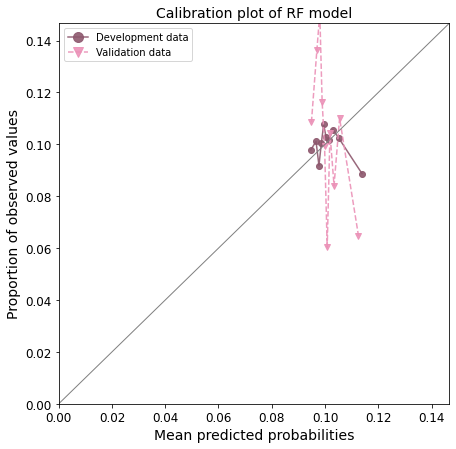

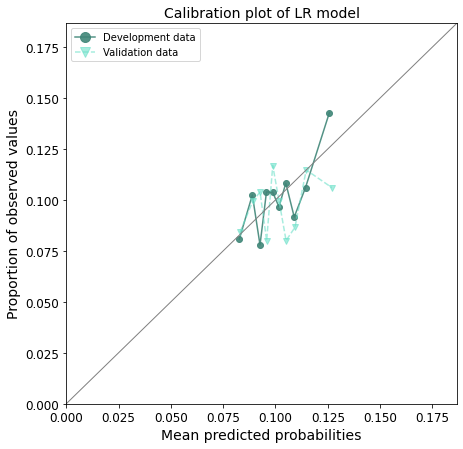

In [ ]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl, prob_pred_sinusitis_no_abs_prevl_bin = cox_build('sinusitis', 'prevl', data_sinusitis_prevl, data_sinusitis_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models with deciles as predictors
    prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('sinusitis', 'prevl_deciles', prob_pred_sinusitis_no_abs_prevl)
    #make summary table of deciles
    make_summary_table_deciles('sinusitis', 'prevl', prob_pred_enc_lr_rf_prevl)
except:
    print("error_2: lr model did not converge or failed to finalise.")

try:
    #calibration plots of rf and lr with deciles
    calibration_rf_lr('sinusitis', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)
except:
    print("error_3: calibration of lr model did not converge or failed to finalise.")

try:
    #build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('sinusitis', 'prevl_riskfactors', prob_pred_sinusitis_no_abs_prevl)
except:
    print("error_4: lr model did not converge or failed to finalise.")

try:
    #calibration plots of rf and lr with risk factors
    calibration_rf_lr('sinusitis', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)
except:
    print("error_5: calibration of lr model did not converge or failed to finalise.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 31250 total observations, 31051 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 31250
number of events observed = 199
   partial log-likelihood = -2046.64
         time fit was run = 2023-06-28 23:02:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.21            -0.56             0.26                 0.57                 1.29
CCI_cat[T.medium]                0.03       1.03       0.22            -0.41             0.46                 0.66                 1.59
CCI_cat[T.high]                 -0.01       0.99       0.27            -0.54             0.52                 0.58                 1.69
CCI_cat[T.very_high]            -0.20       0.82       0.25            -0.69             0.28                 0.50                 1.33
age_cat[T.25_34]                 0.21       1.24       0.25            -0.27             0.70                 0.76                 2.01
age_cat[T.35_44]                -0.09       0.91       0.27            -0.62             0.44                 0.54                 1.55
age_cat[T.45_54]                -0.03       0.97       0.26            -0.54             0.49                 0.58                 1.63
age_cat[T.55_64]                -0.03       0.97       0.26            -0.54             0.49                 0.58                 1.63
age_cat[T.65_74]                -0.29       0.75       0.28            -0.85             0.26                 0.43                 1.30
age_cat[T.75_more]              -0.09       0.92       0.27            -0.61             0.44                 0.54                 1.55
antibacterial_brit               0.01       1.01       0.05            -0.09             0.10                 0.91                 1.11
bmi_cat[T.obese]                -0.16       0.85       0.25            -0.65             0.33                 0.52                 1.39
bmi_cat[T.overweight]           -0.07       0.93       0.31            -0.67             0.53                 0.51                 1.70
bmi_cat[T.underweight]           0.52       1.67       0.36            -0.19             1.22                 0.83                 3.39
bmi_cat[T.unknown]              -0.37       0.69       0.28            -0.92             0.17                 0.40                 1.19
ethnicity[T.other]               0.17       1.18       0.41            -0.64             0.97                 0.53                 2.64
ethnicity[T.unknown]             0.35       1.41       0.33            -0.31             1.00                 0.74                 2.72
ethnicity[T.white]               0.37       1.45       0.31            -0.24             0.99                 0.78                 2.69
flu_vaccine[T.yes]               0.19       1.21       0.22            -0.23             0.62                 0.79                 1.86
imd[T.medium]                    0.13       1.14       0.22            -0.31             0.56                 0.73                 1.76
imd[T.unaffluent]               -0.04       0.96       0.23            -0.50             0.41                 0.61                 1.51
imd[T.unknown]                   0.11       1.11       0.34            -0.56             0.78                 0.57                 2.18
imd[T.very_affluent]            -0.04       0.96       0.23            -0.50             0.41                 0.61                 1.51
imd[T.very_unaffluent]          -0.13       0.88       0.24            -0.59             0.33                 0.55                 1.40
region[T.east_midlands]         -0.07       0.93       0.3

12237


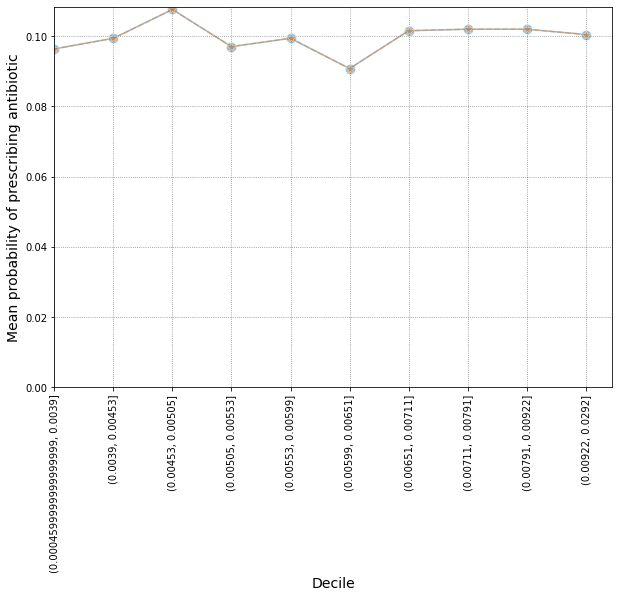


AUROC of LR for deciles with development and validation data: 0.51986 and 0.48380
AUROC of RF for deciles with development and validation data: 0.53672 and 0.49336
LR coefficients:
                                             OR  Lower CI  Upper CI
bins_(0.0004599999999999999, 0.0039]  0.103393  0.091831  0.116411
bins_(0.0039, 0.00453]                0.102631  0.091252  0.115429
bins_(0.00453, 0.00505]               0.118575  0.106093  0.132527
bins_(0.00505, 0.00553]               0.110090  0.098181  0.123444
bins_(0.00553, 0.00599]               0.109328  0.097374  0.122749
bins_(0.00599, 0.00651]               0.094657  0.083749  0.106985
bins_(0.00651, 0.00711]               0.108203  0.096383  0.121473
bins_(0.00711, 0.00791]               0.109561  0.097658  0.122914
bins_(0.00791, 0.00922]               0.116106  0.103743  0.129943
bins_(0.00922, 0.0292]                0.117736  0.105270  0.131678
antibacterial_brit                    1.011114  0.986506  1.036335

RF feature i

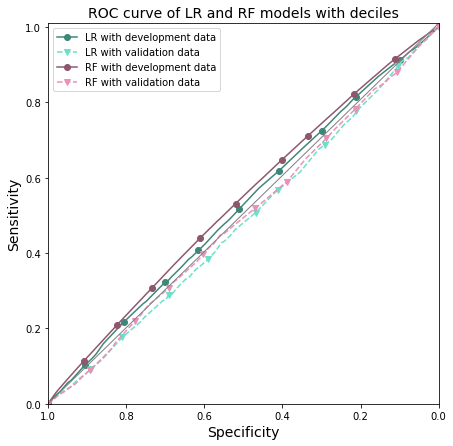

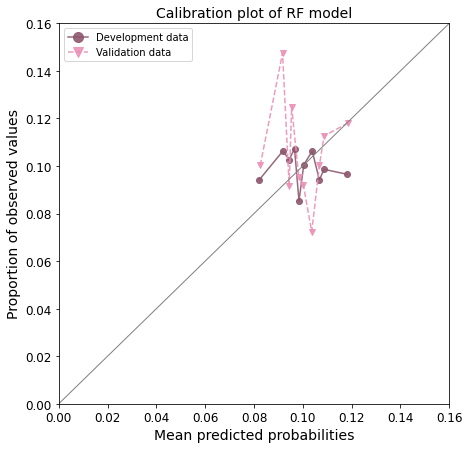

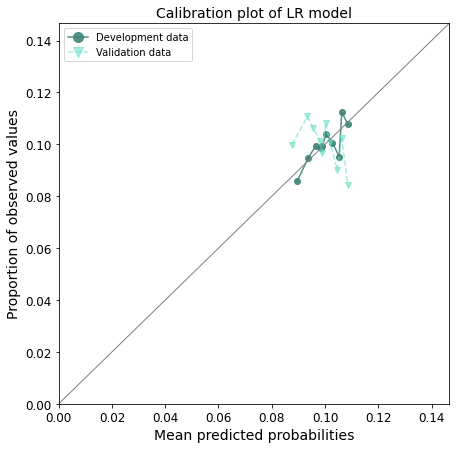

In [ ]:
#build cox model for hosp prediction using non ab users' data
prob_pred_sinusitis_no_abs_incdt_prepandemic, prob_pred_sinusitis_no_abs_incdt_prepandemic_bin = cox_build('sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic, data_sinusitis_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('sinusitis', 'incdt_prepandemic_deciles', prob_pred_sinusitis_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('sinusitis', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 35583 total observations, 35333 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 35583
number of events observed = 250
   partial log-likelihood = -2599.12
         time fit was run = 2023-06-28 23:02:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.19       1.21       0.20            -0.21             0.59                 0.81                 1.80
CCI_cat[T.medium]                0.36       1.44       0.21            -0.06             0.78                 0.94                 2.19
CCI_cat[T.high]                  0.12       1.12       0.27            -0.41             0.64                 0.67                 1.89
CCI_cat[T.very_high]             0.20       1.23       0.23            -0.25             0.65                 0.78                 1.92
age_cat[T.25_34]                -0.01       0.99       0.24            -0.49             0.46                 0.61                 1.59
age_cat[T.35_44]                 0.28       1.32       0.23            -0.17             0.72                 0.84                 2.06
age_cat[T.45_54]                -0.07       0.93       0.25            -0.55             0.41                 0.57                 1.51
age_cat[T.55_64]                 0.02       1.02       0.24            -0.45             0.50                 0.64                 1.64
age_cat[T.65_74]                -0.13       0.88       0.25            -0.63             0.37                 0.54                 1.44
age_cat[T.75_more]               0.21       1.23       0.23            -0.24             0.66                 0.78                 1.94
antibacterial_brit              -0.00       1.00       0.04            -0.09             0.09                 0.92                 1.09
bmi_cat[T.obese]                 0.16       1.18       0.24            -0.32             0.64                 0.73                 1.90
bmi_cat[T.overweight]           -0.14       0.87       0.31            -0.75             0.47                 0.47                 1.59
bmi_cat[T.underweight]           0.23       1.26       0.40            -0.56             1.03                 0.57                 2.80
bmi_cat[T.unknown]              -0.04       0.96       0.27            -0.56             0.48                 0.57                 1.61
ethnicity[T.other]              -0.46       0.63       0.32            -1.09             0.16                 0.34                 1.18
ethnicity[T.unknown]            -0.30       0.74       0.24            -0.76             0.16                 0.47                 1.18
ethnicity[T.white]              -0.34       0.71       0.22            -0.77             0.08                 0.46                 1.09
flu_vaccine[T.yes]               0.43       1.54       0.18             0.08             0.78                 1.08                 2.19
imd[T.medium]                    0.06       1.06       0.23            -0.39             0.50                 0.68                 1.65
imd[T.unaffluent]                0.28       1.32       0.22            -0.14             0.70                 0.87                 2.01
imd[T.unknown]                   0.64       1.91       0.28             0.09             1.20                 1.10                 3.31
imd[T.very_affluent]             0.26       1.30       0.22            -0.16             0.69                 0.85                 1.99
imd[T.very_unaffluent]           0.40       1.49       0.21            -0.02             0.81                 0.98                 2.25
region[T.east_midlands]         -0.05       0.95       0.2

12217


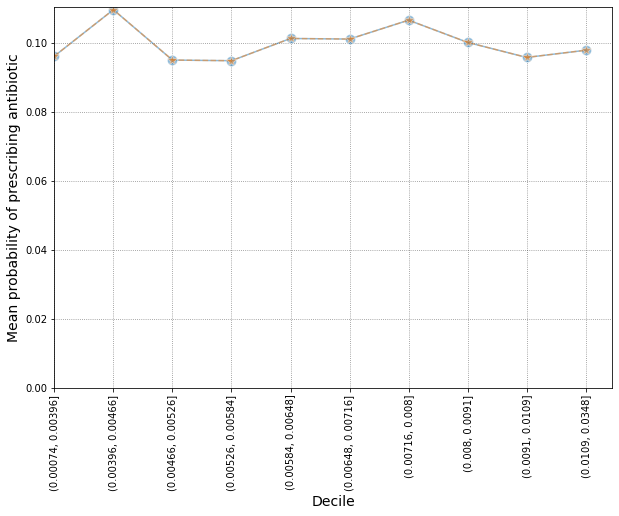


AUROC of LR for deciles with development and validation data: 0.51177 and 0.50915
AUROC of RF for deciles with development and validation data: 0.53460 and 0.49452
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00074, 0.00396]  0.109503  0.098223  0.122078
bins_(0.00396, 0.00466]  0.114334  0.102812  0.127148
bins_(0.00466, 0.00526]  0.103694  0.092771  0.115904
bins_(0.00526, 0.00584]  0.106126  0.095077  0.118460
bins_(0.00584, 0.00648]  0.115562  0.103857  0.128586
bins_(0.00648, 0.00716]  0.110001  0.098722  0.122570
bins_(0.00716, 0.008]    0.118596  0.106826  0.131664
bins_(0.008, 0.0091]     0.111462  0.100080  0.124139
bins_(0.0091, 0.0109]    0.111166  0.099797  0.123829
bins_(0.0109, 0.0348]    0.103952  0.093090  0.116080
antibacterial_brit       0.997127  0.974195  1.020600

RF feature importance:
                           rf_coef
antibacterial_brit       0.598620
bins_(0.00584, 0.00648]  0.062914
bins_(0.00526, 0.00584]  0.055246
bins_(0.

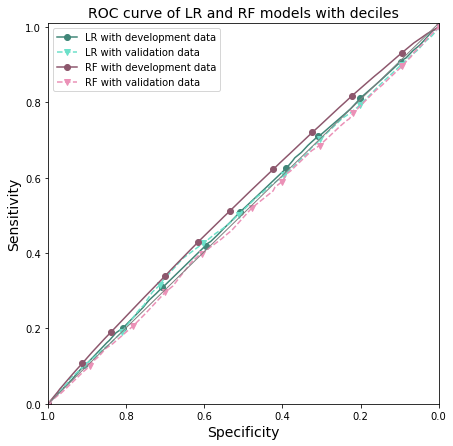

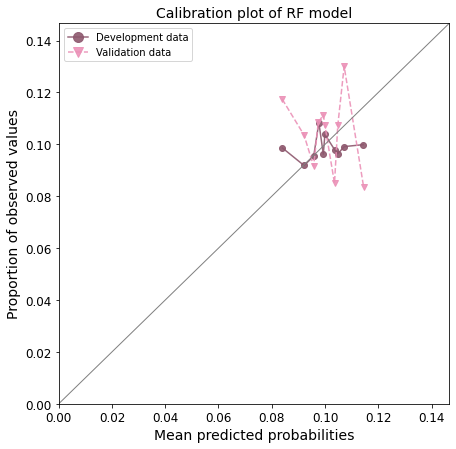

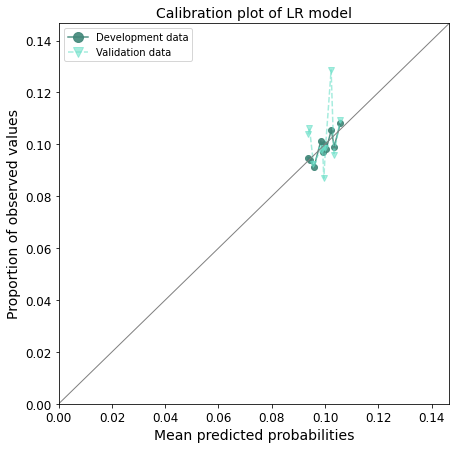

In [ ]:
#build cox model for hosp prediction using non ab users' data
prob_pred_sinusitis_no_abs_incdt_during_pandemic, prob_pred_sinusitis_no_abs_incdt_during_pandemic_bin = cox_build('sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic, data_sinusitis_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('sinusitis', 'incdt_during_pandemic_deciles', prob_pred_sinusitis_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('sinusitis', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 46202 total observations, 45854 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 46202
number of events observed = 348
   partial log-likelihood = -3711.66
         time fit was run = 2023-06-28 23:02:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.16            -0.36             0.26                 0.70                 1.30
CCI_cat[T.medium]               -0.06       0.94       0.18            -0.41             0.28                 0.67                 1.33
CCI_cat[T.high]                 -0.11       0.90       0.22            -0.54             0.31                 0.59                 1.37
CCI_cat[T.very_high]            -0.02       0.98       0.18            -0.37             0.34                 0.69                 1.40
age_cat[T.25_34]                -0.18       0.83       0.20            -0.58             0.22                 0.56                 1.24
age_cat[T.35_44]                 0.16       1.18       0.19            -0.20             0.53                 0.82                 1.69
age_cat[T.45_54]                -0.32       0.73       0.21            -0.74             0.10                 0.48                 1.10
age_cat[T.55_64]                -0.17       0.84       0.20            -0.57             0.23                 0.57                 1.25
age_cat[T.65_74]                -0.14       0.87       0.20            -0.54             0.26                 0.58                 1.30
age_cat[T.75_more]               0.11       1.11       0.19            -0.26             0.48                 0.77                 1.61
antibacterial_brit              -0.04       0.96       0.04            -0.11             0.04                 0.89                 1.04
bmi_cat[T.obese]                -0.34       0.71       0.18            -0.70             0.01                 0.50                 1.01
bmi_cat[T.overweight]           -0.45       0.64       0.24            -0.92             0.02                 0.40                 1.02
bmi_cat[T.underweight]           0.19       1.21       0.29            -0.38             0.77                 0.68                 2.15
bmi_cat[T.unknown]              -0.22       0.80       0.19            -0.60             0.16                 0.55                 1.18
ethnicity[T.other]               0.32       1.37       0.30            -0.28             0.91                 0.76                 2.49
ethnicity[T.unknown]             0.26       1.30       0.26            -0.24             0.76                 0.79                 2.14
ethnicity[T.white]               0.41       1.50       0.24            -0.06             0.88                 0.94                 2.40
flu_vaccine[T.yes]               0.16       1.17       0.17            -0.17             0.49                 0.85                 1.63
imd[T.medium]                    0.17       1.18       0.16            -0.15             0.49                 0.86                 1.63
imd[T.unaffluent]               -0.22       0.80       0.18            -0.58             0.14                 0.56                 1.15
imd[T.unknown]                  -0.24       0.79       0.29            -0.81             0.34                 0.44                 1.40
imd[T.very_affluent]            -0.06       0.94       0.17            -0.40             0.28                 0.67                 1.33
imd[T.very_unaffluent]           0.02       1.02       0.17            -0.31             0.36                 0.73                 1.43
region[T.east_midlands]          0.12       1.12       0.2

12242


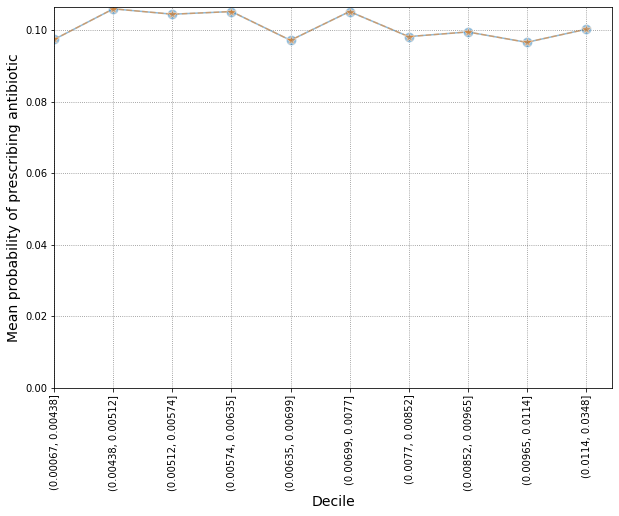


AUROC of LR for deciles with development and validation data: 0.51567 and 0.49048
AUROC of RF for deciles with development and validation data: 0.52549 and 0.49584
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00067, 0.00438]  0.106342  0.096406  0.117302
bins_(0.00438, 0.00512]  0.119630  0.109035  0.131256
bins_(0.00512, 0.00574]  0.111978  0.101867  0.123092
bins_(0.00574, 0.00635]  0.112631  0.102520  0.123739
bins_(0.00635, 0.00699]  0.105313  0.095669  0.115930
bins_(0.00699, 0.0077]   0.120320  0.109896  0.131733
bins_(0.0077, 0.00852]   0.110026  0.100186  0.120834
bins_(0.00852, 0.00965]  0.113009  0.102977  0.124019
bins_(0.00965, 0.0114]   0.104085  0.094607  0.114512
bins_(0.0114, 0.0348]    0.105487  0.095969  0.115950
antibacterial_brit       1.013465  0.993204  1.034139

RF feature importance:
                           rf_coef
antibacterial_brit       0.557531
bins_(0.00699, 0.0077]   0.068776
bins_(0.00438, 0.00512]  0.068366
bins_(0.

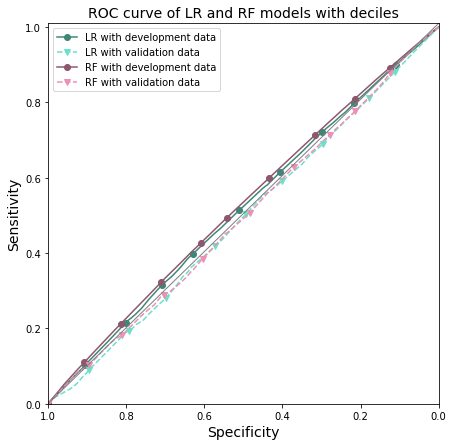

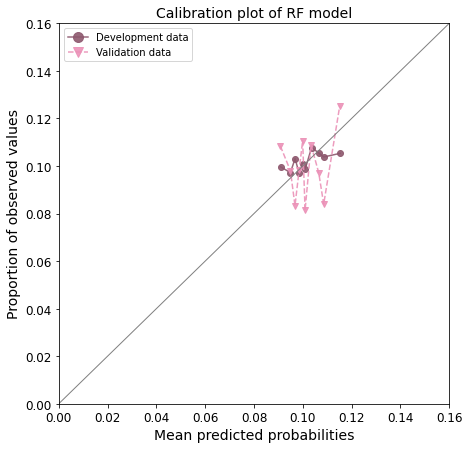

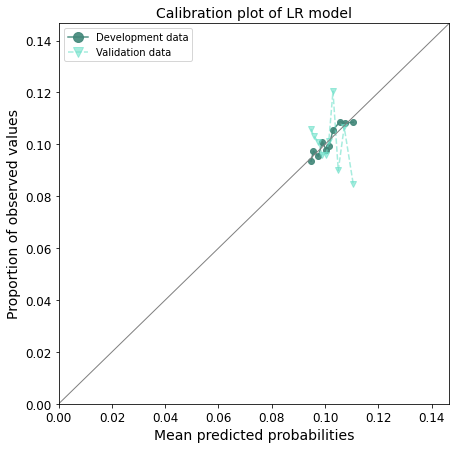

In [ ]:
#build cox model for hosp prediction using non ab users' data
prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown, prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown_bin = cox_build('sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown, data_sinusitis_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('sinusitis', 'incdt_post_2nd_lockdown_deciles', prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('sinusitis', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

In [ ]:
# #build cox model for hosp prediction using non ab users' data
# prob_pred_sinusitis_no_abs_prevl_prepandemic, prob_pred_sinusitis_no_abs_prevl_prepandemic_bin = cox_build('sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic, data_sinusitis_no_abs_prevl_prepandemic)

# #build rf and lr models
# prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('sinusitis', 'prevl_prepandemic_deciles', prob_pred_sinusitis_no_abs_prevl_prepandemic)

# #calibration plots of rf and lr
# calibration_rf_lr('sinusitis', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

In [ ]:
# #build cox model for hosp prediction using non ab users' data
# prob_pred_sinusitis_no_abs_prevl_during_pandemic, prob_pred_sinusitis_no_abs_prevl_during_pandemic_bin = cox_build('sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic, data_sinusitis_no_abs_prevl_during_pandemic)

# #build rf and lr models
# prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('sinusitis', 'prevl_during_pandemic_deciles', prob_pred_sinusitis_no_abs_prevl_during_pandemic)

# #calibration plots of rf and lr
# calibration_rf_lr('sinusitis', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

In [ ]:
# #build cox model for hosp prediction using non ab users' data
# prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown, prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown_bin = cox_build('sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown, data_sinusitis_no_abs_prevl_post_2nd_lockdown)

# #build rf and lr models
# prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('sinusitis', 'prevl_post_2nd_lockdown_deciles', prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown)

# #calibration plots of rf and lr
# calibration_rf_lr('sinusitis', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)